## Load processed data
Use pickle to load the preprocessed data from `datacleaning.ipynb`

In [ ]:
# !python -m spacy download en_core_web_md

In [ ]:
import numpy as np
import pandas as pd
import sys
import datetime
import pickle
from collections import defaultdict

import spacy
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


import experiment_helpers

# Load Processed Data
nlp = spacy.load("../src/en_core_web_md/en_core_web_md-3.2.0")

with open('../data/processed.pickle', 'rb') as handle:
    dictionary = pickle.load(handle)

/shared-libs/python3.8/py/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
all_features = [
    'has_questionmark', 'has_exclamationmark', 'has_period', 
    'num_upper', 'has_digit',
    'char_count', 
    'num_links', 'has_links', 
    'Polarity', 'Subjectivity'
]

random_state = 123

rating_quant_cols = [ # describe each NOTE (one note, many ratings)
    'helpful_quant', 'notHelpful',

        'helpfulInformative', 'helpfulClear', 'helpfulEmpathetic',
        'helpfulGoodSources', 'helpfulUniqueContext', 'helpfulAddressesClaim', 'helpfulOther',
        'helpfulImportantContext',
    
        'notHelpfulOther', 'notHelpfulIncorrect',
        'notHelpfulSourcesMissingOrUnreliable',
        'notHelpfulOpinionSpeculationOrBias', 'notHelpfulMissingKeyPoints',
        'notHelpfulOutdated', 'notHelpfulHardToUnderstand',
        'notHelpfulArgumentativeOrBiased', 'notHelpfulOffTopic',
        'notHelpfulSpamHarassmentOrAbuse', 'notHelpfulIrrelevantSources',
        'helpfulUnbiasedLanguage', 'notHelpfulOpinionSpeculation', 
        'notHelpfulNoteNotNeeded'
]

note_quant_cols = [ # describe each TWEET (one tweet, many notes)
    'classification_quant',

        'believable_quant', 'harmful_quant', 'val_quant',

        'misleadingOther', 'misleadingFactualError', 'misleadingManipulatedMedia',
        'misleadingOutdatedInformation', 'misleadingMissingImportantContext',
        'misleadingUnverifiedClaimAsFact', 'misleadingSatire',
    
        'notMisleadingOther', 'notMisleadingFactuallyCorrect',
        'notMisleadingOutdatedButNotWhenWritten'
]

tweets = dictionary['tweets 02/01/2022']
notes = dictionary['notes 02/01/2022']

tweets.loc[tweets.clean_txt == '', 'clean_txt'] = ' '
notes.loc[notes.clean_txt == '', 'clean_txt'] = ' '



In [ ]:
baseline = [(Pipeline([('most_frequent', DummyClassifier(strategy='most_frequent'))]), 'Most Frequent'),
]

lgb = [(Pipeline([
        ('scaler',StandardScaler()),
        ('lgbm_classifier', lgb.LGBMClassifier(random_state=random_state))]), 'LGBM')
]

In [ ]:
configs = [
    {'pipelines': baseline, 'words':None},
    {'pipelines': lgb, 'words': 'tfidf'},
]

note_idx = list(range(len(notes)))
tweet_idx = list(range(len(tweets)))

quick_results = []
for config in configs:
    kf = KFold(n_splits=5)
    for fold_number, (train_index, test_index) in enumerate(kf.split(tweet_idx)):
        tweets_trn_mask = np.zeros(len(tweets), dtype=bool)
        tweets_trn_mask[train_index] = True
        tweets_test_mask = ~tweets_trn_mask

        tweet_rows = experiment_helpers.run_experiments(
            tweets, nlp, labels=note_quant_cols,
            features=all_features, words=config['words'], 
            trn_mask=tweets_trn_mask, test_mask=tweets_test_mask,
            pipelines=config['pipelines'],
            experiment_identifiers = {
                'type': 'tweets',
                'fold_number': fold_number,
            }
        )
        quick_results += tweet_rows

    for train_index, test_index in kf.split(note_idx):
        notes_trn_mask = np.zeros(len(notes), dtype=bool)
        notes_trn_mask[train_index] = True
        notes_test_mask = ~notes_trn_mask

        note_rows = experiment_helpers.run_experiments(
            notes, nlp, labels=rating_quant_cols,
            features=all_features, words=config['words'],
            trn_mask=notes_trn_mask,
            test_mask=notes_test_mask,
            pipelines=config['pipelines'],
            experiment_identifiers={
                'type': 'notes',
            },
        )
        quick_results += note_rows
quick_results_df = pd.DataFrame(quick_results)

In [ ]:
quick_results

[{'label': 'classification_quant',
  'model_name': 'Most Frequent',
  'trn_mean': 0.9105789633222189,
  'test_mean': 0.8651515151515151,
  'num_trn': 13196,
  'num_test': 3300,
  'accuracy': 0.8651515151515151,
  'roc_auc': 0.5,
  'precision': 0.8651515151515151,
  'recall': 1.0,
  'f1': 0.9277010560519902,
  'type': 'tweets',
  'fold_number': 0,
  'words': None,
  'features': 'has_questionmark,has_exclamationmark,has_period,num_upper,has_digit,char_count,num_links,has_links,Polarity,Subjectivity'},
 {'label': 'believable_quant',
  'model_name': 'Most Frequent',
  'trn_mean': 0.8607911488329797,
  'test_mean': 0.8045454545454546,
  'num_trn': 13196,
  'num_test': 3300,
  'accuracy': 0.8045454545454546,
  'roc_auc': 0.5,
  'precision': 0.8045454545454546,
  'recall': 1.0,
  'f1': 0.8916876574307304,
  'type': 'tweets',
  'fold_number': 0,
  'words': None,
  'features': 'has_questionmark,has_exclamationmark,has_period,num_upper,has_digit,char_count,num_links,has_links,Polarity,Subjectivi

In [ ]:
label_to_acc = {}
for label, group in quick_results_df.groupby(['label']):
    acc = group[group.model_name == 'Most Frequent'].accuracy.iloc[0]
    label_to_acc[label] = acc
quick_results_df['acc_boost'] = quick_results_df.accuracy - quick_results_df.label.map(label_to_acc)

In [ ]:
tweet_labels_with_signal = []
note_labels_with_signal = []
for name, group in quick_results_df.groupby(['label']):
    typ = group['type'].iloc[0]
    print(typ, name)
    if group.roc_auc.max() > 0.55:
        #
        if typ == 'tweets':
            tweet_labels_with_signal.append(name)
        else:
            note_labels_with_signal.append(name)
    else:
        print(  'Less than 0.55')
        print()
    print(group[['words', 'accuracy', 'roc_auc']])
#df1[key_cols].sort_values('label')[key_cols]

tweets believable_quant
     words  accuracy   roc_auc
1     None  0.804545  0.500000
15    None  0.766899  0.500000
29    None  0.862383  0.500000
43    None  0.900273  0.500000
57    None  0.913610  0.500000
191  tfidf  0.896970  0.751106
205  tfidf  0.849045  0.690232
219  tfidf  0.904820  0.663441
233  tfidf  0.900273  0.517568
247  tfidf  0.913610  0.517473
tweets classification_quant
     words  accuracy   roc_auc
0     None  0.865152  0.500000
14    None  0.842073  0.500000
28    None  0.906638  0.500000
42    None  0.943013  0.500000
56    None  0.950591  0.500000
190  tfidf  0.939091  0.823477
204  tfidf  0.916035  0.766133
218  tfidf  0.941801  0.714523
232  tfidf  0.943619  0.517813
246  tfidf  0.950894  0.511792
tweets harmful_quant
     words  accuracy   roc_auc
2     None  0.743636  0.500000
16    None  0.604729  0.500000
30    None  0.649894  0.500000
44    None  0.700515  0.500000
58    None  0.758412  0.500000
192  tfidf  0.830606  0.700603
206  tfidf  0.716278  0.6569

In [ ]:
configs = [
    {'pipelines': baseline, 'words':None},
    {'pipelines': lgb, 'words': 'tfidf'},
    {'pipelines': lgb, 'words': None},
    {'pipelines': lgb, 'words': 'vecs'},
]

results = []
for config in configs:
    kf = KFold(n_splits=5)
    for fold_number, (train_index, test_index) in enumerate(kf.split(tweet_idx)):
        tweets_trn_mask = np.zeros(len(tweets), dtype=bool)
        tweets_trn_mask[train_index] = True
        tweets_test_mask = ~tweets_trn_mask

        tweet_rows = experiment_helpers.run_experiments(
            tweets, nlp, labels=tweet_labels_with_signal,
            features=all_features, words=config['words'], 
            trn_mask=tweets_trn_mask, test_mask=tweets_test_mask,
            pipelines=config['pipelines'],
            experiment_identifiers = {
                'type': 'tweets',
                'fold_number': fold_number,
            }
        )
        results += tweet_rows

    for train_index, test_index in kf.split(note_idx):
        notes_trn_mask = np.zeros(len(notes), dtype=bool)
        notes_trn_mask[train_index] = True
        notes_test_mask = ~notes_trn_mask

        note_rows = experiment_helpers.run_experiments(
            notes, nlp, labels=note_labels_with_signal,
            features=all_features, words=config['words'],
            trn_mask=notes_trn_mask,
            test_mask=notes_test_mask,
            pipelines=config['pipelines'],
            experiment_identifiers={
                'type': 'notes',
            },
        )
        results += note_rows
results_df = pd.DataFrame(results)

In [ ]:
results_df

,label,model_name,trn_mean,test_mean,num_trn,num_test,accuracy,roc_auc,precision,recall,f1,type,fold_number,words,features
0,believable_quant,Most Frequent,0.860791,0.804545,13196,3300,0.804545,0.500000,0.804545,1.000000,0.891688,tweets,0.0,None,"has_questionmark,has_exclamationmark,has_perio..."
1,classification_quant,Most Frequent,0.910579,0.865152,13196,3300,0.865152,0.500000,0.865152,1.000000,0.927701,tweets,0.0,None,"has_questionmark,has_exclamationmark,has_perio..."
2,harmful_quant,Most Frequent,0.678387,0.743636,13196,3300,0.743636,0.500000,0.743636,1.000000,0.852972,tweets,0.0,None,"has_questionmark,has_exclamationmark,has_perio..."
3,misleadingFactualError,Most Frequent,0.613519,0.556061,13196,3300,0.556061,0.500000,0.556061,1.000000,0.714703,tweets,0.0,None,"has_questionmark,has_exclamationmark,has_perio..."
4,misleadingMissingImportantContext,Most Frequent,0.610488,0.562121,13196,3300,0.562121,0.500000,0.562121,1.000000,0.719690,tweets,0.0,None,"has_questionmark,has_exclamationmark,has_perio..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,helpful_quant,LGBM,0.734777,0.718508,13943,3485,0.733716,0.580954,0.755512,0.930511,0.833930,notes,NaN,vecs,"has_questionmark,has_exclamationmark,has_perio..."
236,helpfulAddressesClaim,LGBM,0.318009,0.447346,13943,3485,0.592539,0.565542,0.584242,0.309173,0.404362,notes,NaN,vecs,"has_questionmark,has_exclamationmark,has_perio..."
237,helpfulClear,LGBM,0.393674,0.474605,13943,3485,0.585366,0.582263,0.568977,0.521161,0.544020,notes,NaN,vecs,"has_questionmark,has_exclamationmark,has_perio..."
238,helpfulGoodSources,LGBM,0.375457,0.484935,13943,3485,0.682640,0.685969,0.638520,0.796450,0.708794,notes,NaN,vecs,"has_questionmark,has_exclamationmark,has_perio..."


In [ ]:
for name, group in results_df[results_df.model_name == 'LGBM'].groupby(['label']):
    for name2, group2 in group.groupby('words'):
        print(name, name2, group2.roc_auc.mean())

believable_quant tfidf 0.6279641528945964
believable_quant vecs 0.6269100648768742
classification_quant tfidf 0.6667477979647597
classification_quant vecs 0.6634967506997091
harmful_quant tfidf 0.6751659597293995
harmful_quant vecs 0.6937051649481906
helpfulAddressesClaim tfidf 0.5517169215199054
helpfulAddressesClaim vecs 0.5532911947220565
helpfulClear tfidf 0.5846998621245205
helpfulClear vecs 0.5917119799466195
helpfulGoodSources tfidf 0.6974263675059605
helpfulGoodSources vecs 0.7053815969899473
helpful_quant tfidf 0.5762574774153867
helpful_quant vecs 0.570096368432122
misleadingFactualError tfidf 0.5806326720024886
misleadingFactualError vecs 0.5776618253313306
misleadingMissingImportantContext tfidf 0.5874408713808205
misleadingMissingImportantContext vecs 0.588892963135778
misleadingUnverifiedClaimAsFact tfidf 0.6072022926118819
misleadingUnverifiedClaimAsFact vecs 0.6116952991520455
notMisleadingFactuallyCorrect tfidf 0.6339558595351349
notMisleadingFactuallyCorrect vecs 0.63

In [ ]:
key_cols = ['label', 'model_name', 'words', 'accuracy', 'acc_boost', 'roc_auc',]

In [ ]:
print(len(tweet_labels_with_signal), tweet_labels_with_signal)
print(len(note_labels_with_signal), note_labels_with_signal)

8 ['believable_quant', 'classification_quant', 'harmful_quant', 'misleadingFactualError', 'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact', 'notMisleadingFactuallyCorrect', 'val_quant']
4 ['helpfulAddressesClaim', 'helpfulClear', 'helpfulGoodSources', 'helpful_quant']


In [ ]:
# ===
# Generate a random sample 
# ===
test_frac = 0.20

np.random.seed(123)
np.random.shuffle(note_idx)
np.random.seed(124)
np.random.shuffle(tweet_idx)

num_test_notes = int(len(notes) * test_frac)
num_test_tweets = int(len(tweets) * test_frac)

notes_test_idx = note_idx[:num_test_notes]
tweets_test_idx = tweet_idx[:num_test_tweets]

notes_test_mask = np.zeros(len(notes), dtype=bool)
notes_test_mask[notes_test_idx] = True

tweets_test_mask = np.zeros(len(tweets), dtype=bool)
tweets_test_mask[tweets_test_idx] = True

In [ ]:
train_fracs = [x/11 for x in range(1,11)]
frac_results = []

for seed in range(0,10):
    for i, train_frac in enumerate(train_fracs):
        print(train_frac)
        num_train_notes = int(len(notes) * train_frac)
        num_train_tweets = int(len(tweets) * train_frac)

        notes_train_idx = note_idx[num_test_notes:]
        tweets_train_idx = tweet_idx[num_test_tweets:]

        np.random.seed(seed)
        notes_idx_train_chosen = np.random.choice(notes_train_idx, num_train_notes)
        tweets_idx_train_chosen = np.random.choice(tweets_train_idx, num_train_tweets)

        notes_trn_mask = np.zeros(len(notes), dtype=bool)
        notes_trn_mask[notes_idx_train_chosen] = True

        tweets_trn_mask = np.zeros(len(tweets), dtype=bool)
        tweets_trn_mask[tweets_idx_train_chosen] = True

        tweet_rows = experiment_helpers.run_experiments(
            tweets, nlp, labels=tweet_labels_with_signal,
            features=all_features, words='tfidf', 
            trn_mask=tweets_trn_mask, test_mask=tweets_test_mask,
            pipelines=lgb,
            experiment_identifiers = {
                'type': 'tweets',
                'train_frac': train_frac,
                'seed': 0
                
            }
        )
        frac_results += tweet_rows

        note_rows = experiment_helpers.run_experiments(
            notes, nlp, labels=note_labels_with_signal,
            features=all_features, words='tfidf',
            trn_mask=notes_trn_mask,
            test_mask=notes_test_mask,
            pipelines=lgb,experiment_identifiers={
                'type': 'notes',
                'train_frac': train_frac,
                'seed': 0
            },
        )
        frac_results += note_rows
frac_results_df = pd.DataFrame(frac_results)

0.09090909090909091
0.18181818181818182
0.2727272727272727
0.36363636363636365
0.45454545454545453
0.5454545454545454
0.6363636363636364
0.7272727272727273
0.8181818181818182
0.9090909090909091
0.09090909090909091
0.18181818181818182
0.2727272727272727
0.36363636363636365
0.45454545454545453
0.5454545454545454
0.6363636363636364
0.7272727272727273
0.8181818181818182
0.9090909090909091
0.09090909090909091
0.18181818181818182
0.2727272727272727
0.36363636363636365
0.45454545454545453
0.5454545454545454
0.6363636363636364
0.7272727272727273
0.8181818181818182
0.9090909090909091
0.09090909090909091
0.18181818181818182
0.2727272727272727
0.36363636363636365
0.45454545454545453
0.5454545454545454
0.6363636363636364
0.7272727272727273
0.8181818181818182
0.9090909090909091
0.09090909090909091
0.18181818181818182
0.2727272727272727
0.36363636363636365
0.45454545454545453
0.5454545454545454
0.6363636363636364
0.7272727272727273
0.8181818181818182
0.9090909090909091
0.09090909090909091
0.18181818

In [ ]:
for name, group in frac_results_df.groupby(['label']):
    print(name)
    print(group[['trn_mean', 'num_trn', 'accuracy', 'roc_auc']])

believable_quant
      trn_mean  num_trn  accuracy   roc_auc
0     0.851304     1419  0.886632  0.658526
12    0.843012     2669  0.882995  0.649344
24    0.841261     3805  0.890270  0.658883
36    0.847300     4833  0.890876  0.653060
48    0.848928     5739  0.893907  0.657476
...        ...      ...       ...       ...
1140  0.848388     6543  0.895726  0.650595
1152  0.844942     7236  0.896332  0.652714
1164  0.846887     7870  0.897848  0.653598
1176  0.845044     8383  0.896029  0.651654
1188  0.846958     8893  0.896029  0.649889

[100 rows x 4 columns]
classification_quant
      trn_mean  num_trn  accuracy   roc_auc
1     0.901339     1419  0.938163  0.723311
13    0.891720     2669  0.942104  0.720926
25    0.892773     3805  0.942104  0.725477
37    0.894475     4833  0.942104  0.719409
49    0.895452     5739  0.944226  0.729676
...        ...      ...       ...       ...
1141  0.897906     6543  0.944832  0.717874
1153  0.897872     7236  0.944529  0.717707
1165  0.900254

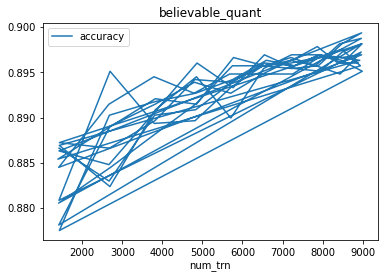

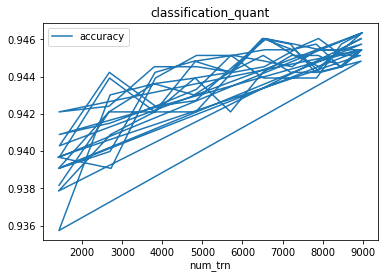

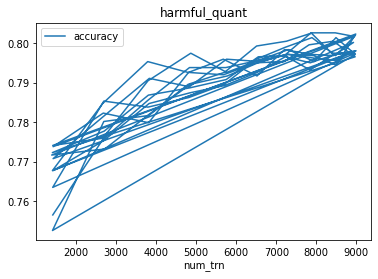

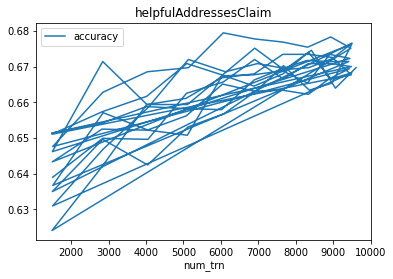

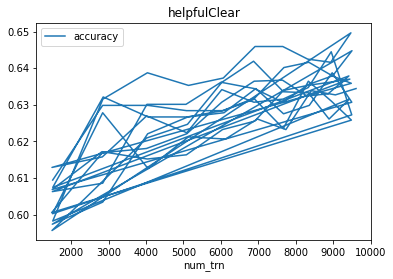

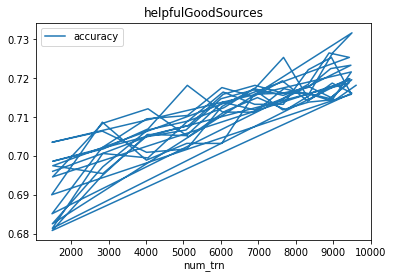

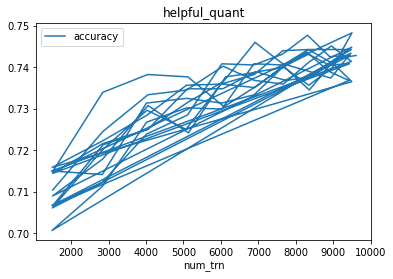

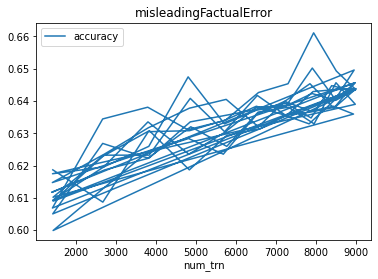

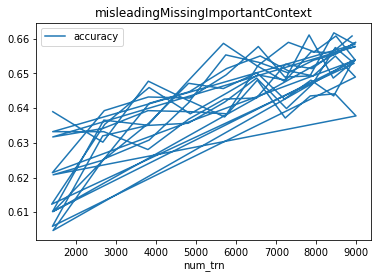

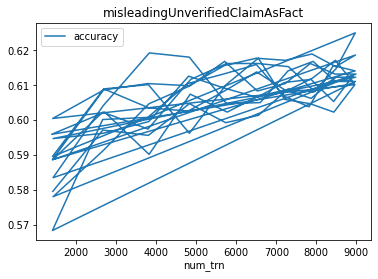

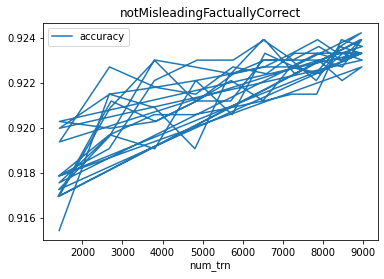

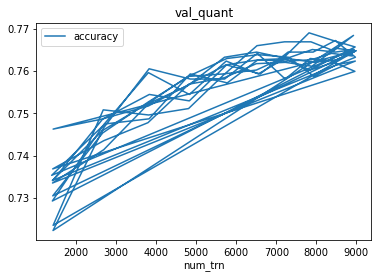

In [ ]:
for name, group in frac_results_df.groupby(['label']):
    group.plot('num_trn', 'accuracy')
    plt.title(name)

In [ ]:
dates = [
    '04/01/2021', #'04/15/2021', 
    '06/01/2021', #'06/15/2021',
    '08/01/2021', # '08/15/2021',
    '10/01/2021', # '10/15/2021',
    '12/01/2021',
    '02/01/2022'
]

date_results = []
window_size_in_days = 60
for date in dates:
    notes_d = dictionary['notes ' + date]
    tweets_d = dictionary['tweets ' + date]
    
    dt = pd.to_datetime(date)
    test_start_dt = dt - datetime.timedelta(days=window_size_in_days)
    print(dt, test_start_dt)

    # create datetime column
    notes_d['dt'] = notes.createdAtMillis.apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    tweets_d['dt'] = tweets_d.createdAtMillis.apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    
    notes_trn_mask = notes_d.dt < test_start_dt
    notes_test_mask = ~notes_trn_mask

    tweets_trn_mask = tweets_d.dt < test_start_dt
    tweets_test_mask = ~tweets_trn_mask

    tweet_rows = experiment_helpers.run_experiments(
        tweets_d, nlp, labels=tweet_labels_with_signal,
        features=all_features, words='tfidf', 
        trn_mask=tweets_trn_mask, test_mask=tweets_test_mask,
        pipelines=lgb,
        experiment_identifiers = {
            'type': 'tweets',
            'date': date
            
        }
    )
    date_results += tweet_rows

    note_rows = experiment_helpers.run_experiments(
        notes_d, nlp, labels=note_labels_with_signal,
        features=all_features, words='tfidf',
        trn_mask=notes_trn_mask,
        test_mask=notes_test_mask,
        pipelines=lgb,experiment_identifiers={
            'type': 'notes',
            'date': date
        },
    )
    date_results += note_rows

date_results_df = pd.DataFrame(date_results)



2021-04-01 00:00:00 2021-01-31 00:00:00
2021-06-01 00:00:00 2021-04-02 00:00:00
2021-08-01 00:00:00 2021-06-02 00:00:00
2021-10-01 00:00:00 2021-08-02 00:00:00
2021-12-01 00:00:00 2021-10-02 00:00:00
2022-02-01 00:00:00 2021-12-03 00:00:00


In [ ]:
date_results_df

,label,model_name,trn_mean,test_mean,num_trn,num_test,accuracy,roc_auc,precision,recall,f1,type,date,words,features
0,believable_quant,LGBM,0.540404,0.741836,792,2909,0.787900,0.692526,0.835146,0.889713,0.861566,tweets,04/01/2021,tfidf,"has_questionmark,has_exclamationmark,has_perio..."
1,classification_quant,LGBM,0.641414,0.829838,792,2909,0.899278,0.777111,0.920000,0.962303,0.940676,tweets,04/01/2021,tfidf,"has_questionmark,has_exclamationmark,has_perio..."
2,harmful_quant,LGBM,0.462121,0.651770,792,2909,0.668271,0.643684,0.756192,0.724684,0.740102,tweets,04/01/2021,tfidf,"has_questionmark,has_exclamationmark,has_perio..."
3,misleadingFactualError,LGBM,0.338384,0.505672,792,2909,0.556205,0.557743,0.584746,0.422162,0.490328,tweets,04/01/2021,tfidf,"has_questionmark,has_exclamationmark,has_perio..."
4,misleadingMissingImportantContext,LGBM,0.304293,0.491922,792,2909,0.569612,0.567488,0.583723,0.436059,0.499200,tweets,04/01/2021,tfidf,"has_questionmark,has_exclamationmark,has_perio..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,val_quant,LGBM,0.266335,0.323410,14279,2217,0.745602,0.622711,0.817427,0.274756,0.411273,tweets,02/01/2022,tfidf,"has_questionmark,has_exclamationmark,has_perio..."
68,helpfulAddressesClaim,LGBM,0.316789,0.499806,14849,2579,0.551764,0.551646,0.631683,0.247479,0.355630,notes,02/01/2022,tfidf,"has_questionmark,has_exclamationmark,has_perio..."
69,helpfulClear,LGBM,0.400633,0.462970,14849,2579,0.591314,0.582131,0.573375,0.458124,0.509311,notes,02/01/2022,tfidf,"has_questionmark,has_exclamationmark,has_perio..."
70,helpfulGoodSources,LGBM,0.385683,0.464521,14849,2579,0.689802,0.694814,0.638579,0.765442,0.696279,notes,02/01/2022,tfidf,"has_questionmark,has_exclamationmark,has_perio..."


In [ ]:
o = {}
o['quick_results_df'] = quick_results_df
o['frac_results_df'] = frac_results_df
o['date_results_df'] = date_results_df
o['results_df'] = results_df

with open('../i_data/predictions.pickle', 'wb') as handle:
    pickle.dump(o, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
for name, group in results_df.groupby(['label']):
    print(name,group.trn_mean.mean())

believable_quant 0.8495394527718243
classification_quant 0.9014914083346717
harmful_quant 0.6914401513584923
helpfulAddressesClaim 0.34387219382955503
helpfulClear 0.4098578620809093
helpfulGoodSources 0.397349265720086
helpful_quant 0.7315240155440332
misleadingFactualError 0.6020249074675799
misleadingMissingImportantContext 0.600812464772701
misleadingUnverifiedClaimAsFact 0.4946046816880843
notMisleadingFactuallyCorrect 0.09741745525629143
val_quant 0.2740061907940489


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0e62a2c-7f45-414e-8164-5bf51e09d482' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>